In [1]:
import numpy as np
import os
from astropy.io import fits
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.nddata import CCDData
from skimage.measure import profile_line
from scipy.signal import find_peaks
from ccdproc import wcs_project
from scipy.signal import convolve2d
from astropy.convolution import convolve,convolve_fft
from scipy.ndimage import shift,rotate
from reproject import reproject_interp, reproject_exact, reproject_adaptive
from reproject.mosaicking import find_optimal_celestial_wcs
import cv2
from photutils.centroids import (centroid_1dg, centroid_2dg,centroid_com, centroid_quadratic, centroid_sources)

In [2]:
def openPSF(directory, filt):
    psffilename = directory+'WR140_F'+filt+'W_psf.fits'
    psffits = fits.open(psffilename)
    header_psf = psffits[1].header
    psf = psffits[3].data
    
    return psf

In [93]:
def lineProfileMaker(img,srcx,srcy,dstx,dsty):
    d = 5.06e+16 #distance from us in kilometers, GAIA DR3 
    pix_width_rad = 0.11 #miri pixel scale = 0.11 arcsec -> radians = arcsec * 4.8481e-6
    pixel_size = d*(pix_width_rad/206265) #width of pixels in kilometers  <---- make this more precise
    pixel_size_au = pixel_size*6.68459e-9
    
    profiles = []
    endsx = []
    endsy = []
#     prof_len = len(profile_line(img,(srcy,srcx),(dsty+30,dstx+30), linewidth=3))-1
    
    for i in np.arange(0,40,1):
        profile = profile_line(img,(srcy,srcx),(dsty+i,dstx+i), linewidth=3)
        endsx.append(dstx+i)
        endsy.append(dsty+i)
#         print(len(profile))
        profiles.append(profile[0:308]) # C1 = 341
        profile_xaxis = np.arange(0,len(profiles[0]),1)*pixel_size_au
    profiles=np.array(profiles,dtype='object')
#     for j in range(len(profiles)):
#         for k in range(len(profiles[0])):
#             mean_profile = np.sum(profiles[j][k])/len(profiles)
    peaks,properties = find_peaks(np.median(profiles,axis=0),distance = 15,height = [100,250])#, threshold = 0)
    valleys, _ = find_peaks(np.median(profiles,axis=0)*-1,distance=15,height = [-250,-100])#,height=[0,125])
#     plt.plot(profile_xaxis*-1,np.mean(profiles,axis=0)*-1)
    q=peaks/(len(np.median(profiles,axis=0)))
    v = valleys/(len(np.median(profiles,axis=0)))
    xpeaks=srcx+(np.median(endsx,axis=0)-srcx)*q
    ypeaks=srcy+(np.median(endsy,axis=0)-srcy)*q
    xvalleys=srcx+(np.median(endsx,axis=0)-srcx)*v
    yvalleys=srcy+(np.median(endsy,axis=0)-srcy)*v
#     print(profiles[0])
    
    return np.median(profiles,axis=0),endsx,endsy,profile_xaxis,peaks, valleys, xpeaks, ypeaks, xvalleys, yvalleys

In [4]:
def openFitsImage(directory,filt,cycle):
    file = directory+'miri_F'+filt+'W_pid'+cycle+"_combined_asn_i2d.fits"

    imgfits = fits.open(file)

    img = imgfits[1].data
    
    hdu = fits.open(file)[1]
    
    wcs = WCS(hdu.header)
    
    return img,wcs,imgfits, hdu.header

In [5]:
def openFitsConvolvedModel(directory,w):
    file = directory+"model_convolved.fits"
    modelfits = fits.open(file)
    model = modelfits.data
#     w = WCS(modelfits['SCI'].header).celestial
#     sky = w.pixel_to_world(30, 40)
#     print(sky)
#     header = w.to_header
#     print(w)

#     modeldata = CCDData.read(file, unit = 'flx', wcs=w)

#     model = modeldata[0].data
#     print(modeldata.wcs)
    
    return model, modelfits

In [6]:
def openFitsModel(directory):
    file = directory+"WR140_geometricmodel.fits"
    modelfits = fits.open(file)
    model = modelfits[1].data
    w = WCS(modelfits['SCI'].header).celestial
    sky = w.pixel_to_world(30, 40)
    print(sky)
    header = w.to_header
    print(w)

    modeldata = CCDData.read(file, unit = 'flx', wcs=w)

#     model = modeldata[0].data
#     print(modeldata.wcs)
    
    return modeldata, modelfits, w

In [7]:
model_dir = "/Users/emmalieb/PycharmProjects/WRBinaries/WR140DustPaper/Modeling/Wolf-Rayets-main/"
img_dir = "/Users/emmalieb/WR140Paper/mastDownload/WR140_Cy1Cy2_PSFSubbed_Final/"
psf_dir = "/Users/emmalieb/WR140Paper/"

filt = "770"
cycle1 = "1349058001"
cycle2 = "3823004001"

img,wcs,hdu1,hdr1 = openFitsImage(img_dir, filt, cycle1)
img2,wcs2,hdu2,hdr2 = openFitsImage(img_dir, filt, cycle2)

yshape,xshape = np.shape(img)

model,hdu3,w = openFitsModel(model_dir)
# model_conv,model_conv_fits = openFitsConvolvedModel(model_dir,w)

psf = openPSF(psf_dir, filt)

<SkyCoord (ICRS): (ra, dec) in deg
    (305.07555728, 43.85181699)>
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 305.11074173843707 43.85116358827798 
CRPIX : 613.1146142636346 623.9297808528415 
PC1_1 PC1_2  : 0.7247402503052925 0.6890221836685826 
PC2_1 PC2_2  : 0.6890221836685826 -0.7247402503052925 
CDELT : 3.08095635265991e-05 3.08095635265991e-05 
NAXIS : 906  906
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: using the unit flx passed to the FITS reader instead of the unit MJy/sr in the FITS file. [astropy.nddata.ccddata]


Set DATE-AVG to '2022-07-27T15:57:56.109' from MJD-AVG.
Set DATE-END to '2022-07-27T16:18:02.560' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.877833 from OBSGEO-[XYZ].
Set OBSGEO-H to 1712747367.816 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T00:11:15.853' from MJD-AVG.
Set DATE-END to '2023-09-09T00:31:06.614' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -7.230459 from OBSGEO-[XYZ].
Set OBSGEO-H to 1346337294.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    -7.235357 from OBSGEO-[XYZ].
Set OBSGEO-H to 1346386290.631 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T00:11:15.853' from MJD-AVG.
Set DATE-END to '2023-09-09T00:31:06.614' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -7.235357 from OBSGEO-[XYZ].
Set OBSGEO-H to 1346386290.631 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [8]:
#takes a long time to run on my computer
print(np.shape(psf))
y_shape, x_shape = np.shape(psf)
psf =psf[0:y_shape-1,0:x_shape-1]
model_conv = convolve_fft(model, psf)
# hdu = fits.PrimaryHDU(model_conv)
# hdu.writeto(outfile, overwrite=True)
# else:
#     model_conv = openFitsModel(model_dir,)

(1300, 1300)


In [22]:
wcs_opt,_ = find_optimal_celestial_wcs([hdu1[1]])

model_tuple = (model_conv,wcs)

img_new = reproject_interp(hdu1[1], wcs_opt,shape_out = (1300,1300))[0]#make images larger
img2_new = reproject_interp(hdu2[1], wcs_opt,shape_out = (1300,1300))[0]#make images larger
model_new = reproject_interp(model_tuple, wcs,shape_out = (1300,1300))[0]

#move science to center of model 
#the most precise centroid may be the filter to use 
#use a subtraction (residuals) to see how well aligned they are - something to include in paper for sure
#models show column density - different line profile - compensate or scale model to expected emission 

# wcs_project(model,wcs)
print(wcs_opt)

Set DATE-AVG to '2022-07-27T15:57:56.109' from MJD-AVG.
Set DATE-END to '2022-07-27T16:18:02.560' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.877833 from OBSGEO-[XYZ].
Set OBSGEO-H to 1712747367.816 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T00:11:15.853' from MJD-AVG.
Set DATE-END to '2023-09-09T00:31:06.614' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -7.230459 from OBSGEO-[XYZ].
Set OBSGEO-H to 1346337294.484 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 305.10884891628734 43.85545025964282 
CRPIX : 652.0874085584276 658.6804889189151 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -3.08106311553821e-05 3.08106311553821e-05 
NAXIS : 0  0


In [120]:
model_new[np.isnan(model_new)]=0
mcx, mcy = 452,454
x_init, y_init = 472,628
# mcx1,mcy1 = centroid_2dg(model_new)
# print(mcx1,mcy1)
# icx,icy = centroid_2dg(img)
# print(icx,icy)
endx, endy = 650,370
# xycen1 = centroid_sources(img, x_init, y_init, box_size=115,centroid_func=centroid_com)
# xycen2 = centroid_sources(img, x_init, y_init, box_size=15,centroid_func=centroid_quadratic)
# xycen3 = centroid_sources(img, x_init, y_init, box_size=15,centroid_func=centroid_1dg)
# xycen = centroid_sources(img, x_init, y_init, box_size=15,centroid_func=centroid_2dg)
# xycenm = centroid_sources(model_new, x_init, y_init, box_size=15,centroid_func=centroid_2dg)
# xycens = [xycen1, xycen2,xycen3, xycen4]
# print(xycens)

imgnorm = simple_norm(img_new, 'log', vmin =  0, vmax = 1000.)
img2norm = simple_norm(img2_new, 'log', vmin =  0, vmax = 1000.)
modelnorm = simple_norm(model_new, 'log', vmin =  0, vmax = 1)

OffsetIm = fits.PrimaryHDU()
OffsetIm.header['CRPIX1'] = 400 #477 #Center x coordinate
OffsetIm.header['CRPIX2'] = 400 #635 # Center y coordinate
OffsetIm.header['CTYPE1'] = 'RA---TAN'
OffsetIm.header['CTYPE2'] = 'DEC--TAN'
OffsetIm.header['CDELT1'] = -3.08086883087735e-05#-3.08106296124805e-05
OffsetIm.header['CDELT2'] = 3.08086883087735e-05 #3.08106296124805e-05 
OffsetImwcs = WCS(OffsetIm.header)
# OffsetImwcs.wcs.crval = np.array([198.17054090794878,-62.72205963116597]) 
OffsetImwcs.wcs.crval = np.array([0,0]) 



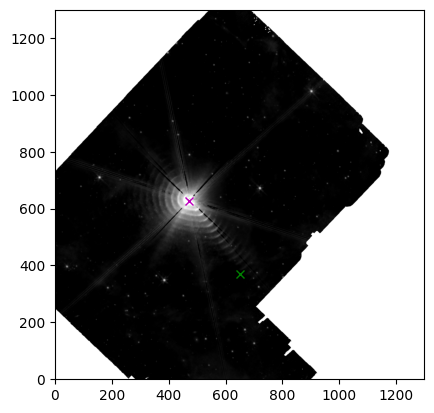

In [121]:
plt.imshow(img2_new,origin='lower', norm = img2norm, cmap = 'Greys_r')
# plt.plot(xycenm,marker = "x",c="w")
plt.plot(x_init,y_init,marker = "x",c="m")
plt.plot(endx,endy,marker="x",c="green")
# plt.ylim(400,1000)
# plt.xlim(400,1000)

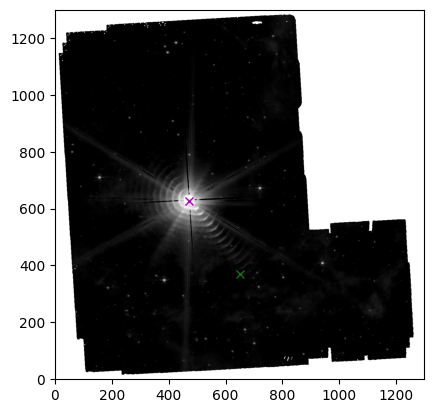

In [122]:
plt.imshow(img_new,origin='lower', norm = img2norm, cmap = 'Greys_r')
# plt.plot(xycenm,marker = "x",c="w")
plt.plot(x_init,y_init,marker = "x",c="m")
plt.plot(endx,endy,marker="x",c="green")
# plt.ylim(400,1000)
# plt.xlim(400,1000)

0.5963843162799316


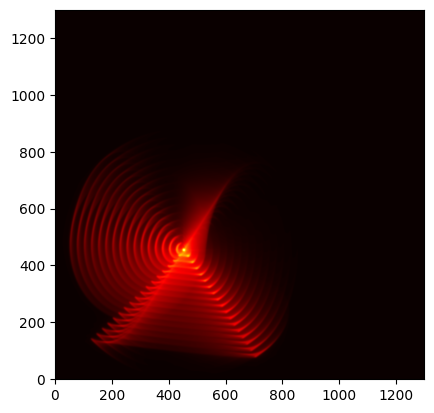

In [109]:
plt.imshow(model_new, norm = modelnorm,origin='lower', cmap = 'hot')
print(np.nanmax(model_new))

(402.0, 502.0)

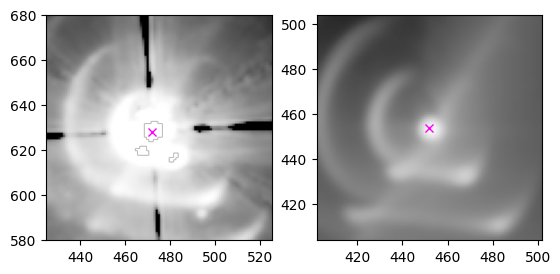

In [124]:
plt.subplot(1, 2, 1)#, projection = OffsetImwcs)
plt.imshow(img_new, norm = imgnorm,cmap = "Greys_r", origin = 'lower')
plt.plot(x_init,y_init,marker = "x", color = "magenta")
plt.ylim(icy-50,icy+50)
plt.xlim(icx-50,icx+50)

plt.subplot(1, 2, 2)#, projection = OffsetImwcs)
plt.imshow(model_new, norm = modelnorm,cmap = "Greys_r", origin = 'lower')
plt.plot(mcx,mcy,marker = "x", color = "magenta")
plt.ylim(mcy-50,mcy+50)
plt.xlim(mcx-50,mcx+50)

# plt.show()
# marker = '+'
# ms, mew = 15, 1
# plt.savefig("side_by_side.pdf", dpi = 300)
# colors = ('black', 'orange', 'red', 'blue')
# for xycen, color in zip(xycens, colors):
#     plt.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)

# ind = np.where(model == np.nanmax(model))
# print(ind)
# ax.contour(model, transform=ax.get_transform(wcs),levels=[1,2,3,4,5,6], colors='white')
# plt.show()

-20 -174


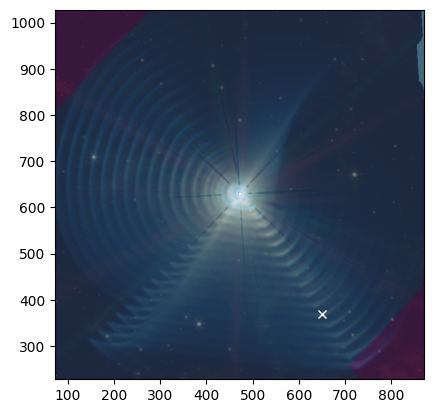

In [125]:
plt.subplot()#projection=wcs)
# model_rotated = rotate(model, 127,prefilter = False)
# print(np.nanmax(model_rotated))
# mcx,mcy = centroid_2dg(model_rotated)
# print(mcx,mcy)
icx,icy = x_init, y_init
xdiff = mcx-icx
ydiff = mcy-icy
print(xdiff,ydiff)
model_shifted = shift(model_new,(-ydiff,-xdiff),prefilter = False)

# modelnorm = simple_norm(model, 'log', min_cut =  0, max_cut = 1)
# plt.imshow(model_new, origin = 'lower',norm = modelnorm, cmap = "Greys")
plt.imshow(model_shifted, origin = 'lower', norm = modelnorm,cmap = "Blues_r", alpha = 0.5,zorder=2)
plt.imshow(img_new,norm=imgnorm,origin='lower',cmap = "Reds_r",zorder=1)
plt.imshow(img2_new,norm=imgnorm,origin='lower',cmap = "Greens_r",zorder=1,alpha = 0.5)
# plt.plot(xycenm,marker = "x",c="w")
plt.plot(endx,endy,marker = "x",c="w")
# plt.plot(mcx,mcy,marker = "x", color = "magenta")
plt.ylim(icy-400,icy+400)
plt.xlim(icx-400,icx+400)
plt.show()

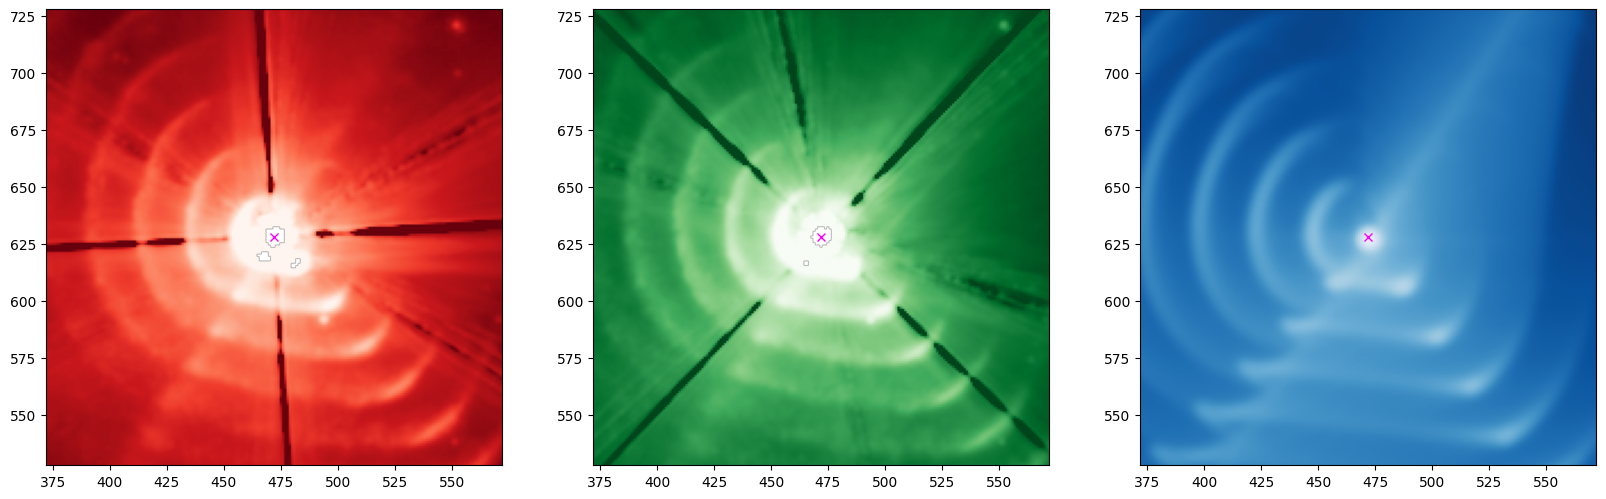

In [143]:
fig = plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
norm = simple_norm(img, 'log', vmin =  0, vmax = 1000.)
plt.imshow(img_new, norm = norm, origin = 'lower',cmap = "Reds_r")
plt.plot(icx,icy,marker = "x", color = "magenta")
plt.ylim(icy-100,icy+100)
plt.xlim(icx-100,icx+100)

plt.subplot(1, 3, 2)
norm = simple_norm(img, 'log', vmin =  0, vmax = 1000.)
plt.imshow(img2_new, norm = norm, origin = 'lower',cmap = "Greens_r")
plt.plot(icx,icy,marker = "x", color = "magenta")
plt.ylim(icy-100,icy+100)
plt.xlim(icx-100,icx+100)

plt.subplot(1, 3, 3)
modelnorm = simple_norm(model, 'log', vmin =  0, vmax = 1)
plt.imshow(model_shifted, norm = modelnorm, origin = 'lower',cmap = "Blues_r")#,alpha = 0.5)
plt.plot(icx,icy,marker = "x", color = "magenta")
plt.ylim(icy-100,icy+100)
plt.xlim(icx-100,icx+100)
# plt.show()
# marker = '+'
# ms, mew = 15, 1
plt.savefig("side_by_side_aligned.pdf", dpi = 300)

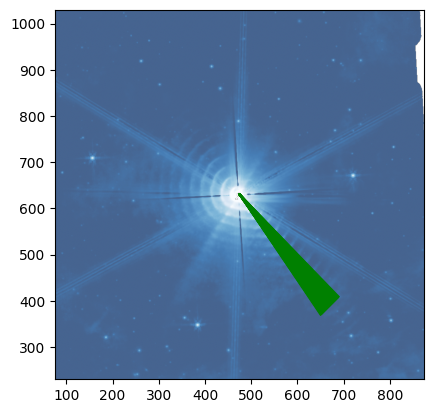

In [113]:

# img_shifted = shift(img,(ydiff,xdiff))
# plt.subplot(projection=OffsetImwcs)
# fig, ax1 = plt.figure(projection=wcs)
# ax2 = ax1.twinx().twiny()
# modelnorm = simple_norm(model, 'log', min_cut =  0, max_cut = 1)
# plt.imshow(model_shifted, origin = 'lower',norm = modelnorm, cmap = "Reds_r")

imgnorm = simple_norm(img, 'log', min_cut =  0, max_cut = 1000)
plt.imshow(img_new, norm = imgnorm,origin = 'lower',cmap = "Blues_r", alpha = 0.75)
plt.ylim(icy-400,icy+400)
plt.xlim(icx-400,icx+400)

# cm = matplotlib.colormaps.get_cmap("Greens") #you can choose the colormap here
# num_colors = len(np.unique(end_points_x)) 
# ax.set_prop_cycle(color = [cm(1.*i/num_colors) for i in range(num_colors)])
# loop through the unique x values
# for i in np.unique(end_points_x):
#     print(i)
#     ind = np.where(end_points_x == i)
# plt.scatter(xpeaks_img,ypeaks_img,marker = "x", c="r",zorder=2)
# plt.scatter(xvalleys1521,yvalleys1521,marker = "x", c="b",zorder=2)
for i in range(len(end_points_x)):
    plt.plot([int(icx),end_points_x[i]],[int(icy),end_points_y[i]],zorder=1,c="g")
# .set_aspect('equal')
# plt.show()
# plt.savefig("overlay.pdf",dpi = 300)

In [ ]:
# img8bit = cv2.normalize(img, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX).astype('uint8')
# # img8bit = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)#, dtype=cv2.CV_32F)
# sift = cv2.SIFT_create()
# kp = sift.detect(img8bit,None)
# imgnew=cv2.drawKeypoints(img8bit,kp,img)
# # norm8bit = simple_norm(img8bit, 'log', min_cut =  0, max_cut = 1)
# plt.imshow(img8bit, norm = norm8bit, cmap = "Greys")
# print(len(kp))

113.45820443375098
-5586.770408013476


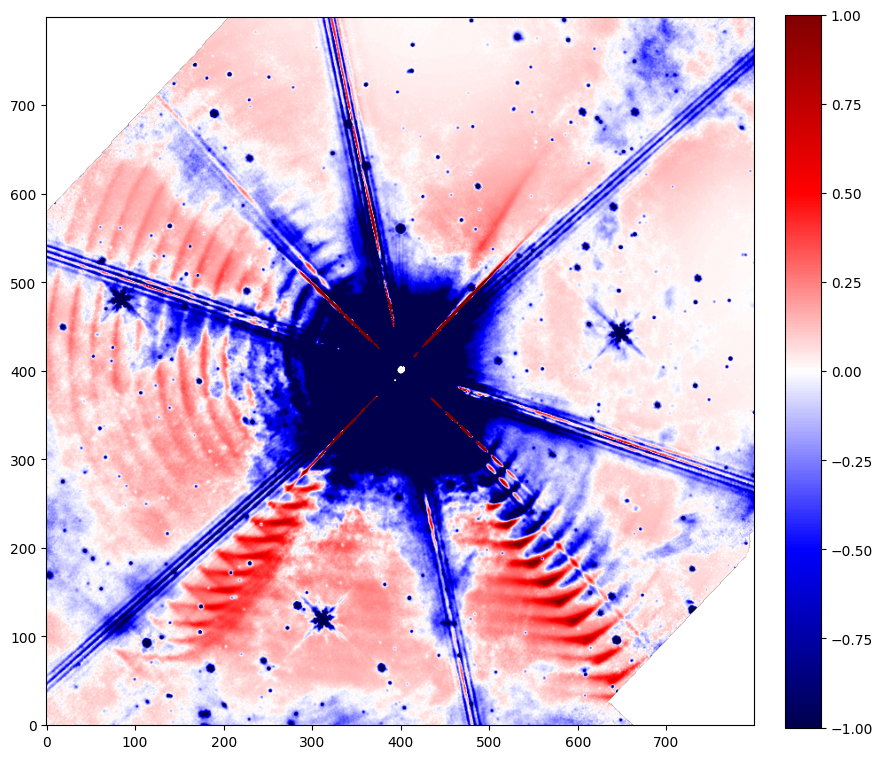

In [141]:
# y_shape,x_shape = np.shape(model)
img_diff = img2_new[icy-400:icy+400,icx-400:icx+400]#/np.nanmax(img)
model_diff = model_shifted[icy-400:icy+400,icx-400:icx+400]*100
diff = model_diff - img_diff
# normalized_diff = diff/np.nanmax(diff)
print(np.nanmax(diff))
print(np.nanmin(diff))
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)#, projection=OffsetImwcs) 
diffnorm = simple_norm(diff, 'linear', vmin =  -1, vmax = 1)
# plt.subplot(projection=OffsetImwcs)
plt.imshow(diff,norm=diffnorm,origin = 'lower',cmap = "seismic")
plt.colorbar(cm.ScalarMappable(norm = diffnorm,cmap="seismic"), ax=ax,fraction=0.046, pad=0.04)
# plt.ylim(1000,400)
# plt.xlim(400,1000)
# plt.show()
plt.savefig("Residuals_cycle2.pdf",dpi=300)

In [96]:
prof_img, end_points_x, end_points_y, prof_xaxis_img, peaks_img, valleys_img, xpeaks_img, ypeaks_img, xvalleys_img, yvalleys_img = lineProfileMaker(img_new, int(icx),int(icy),int(endx),int(endy))
prof_img2, end_points_x, end_points_y, prof_xaxis_img2, peaks_img, valleys_img, xpeaks_img, ypeaks_img, xvalleys_img, yvalleys_img = lineProfileMaker(img2_new, int(icx),int(icy),int(endx),int(endy))
prof_model, end_points_x, end_points_y, prof_xaxis_model, peaks_model, valleys_model, xpeaks_model, ypeaks_model, xvalleys_model, yvalleys_model = lineProfileMaker(model_shifted, int(icx),int(icy),int(endx),int(endy))


Text(0.5, 0, 'Distance from WR140 [au]')

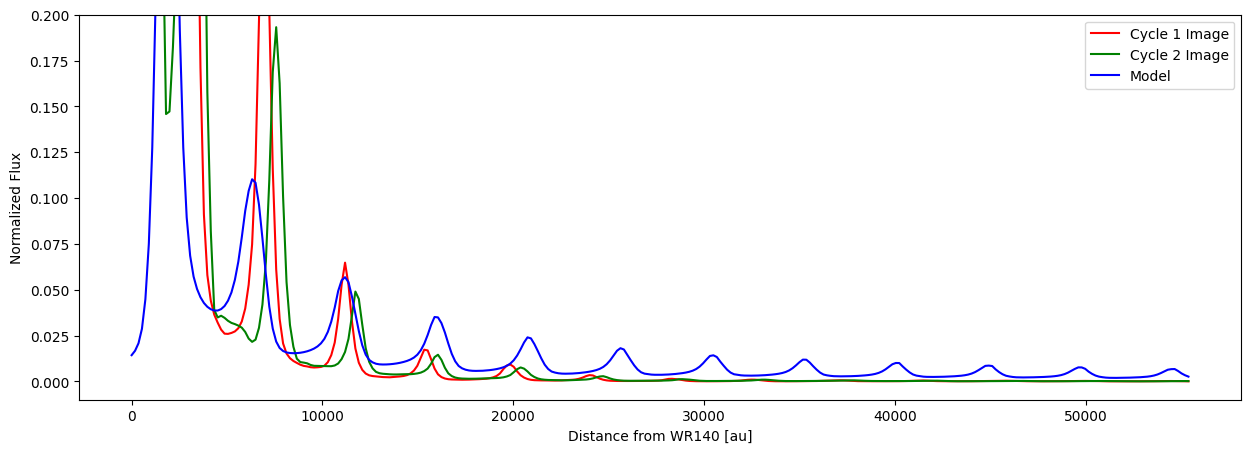

In [148]:
# fig,ax = plt.subplots(figsize=(15,5))
fig = plt.figure(figsize=(15,5))
# ax2 = ax.twinx()
plt.plot(prof_xaxis_img,prof_img/np.nanmax(prof_img),c="red",label="Cycle 1 Image")
plt.plot(prof_xaxis_img2,prof_img2/np.nanmax(prof_img2),c="green",label="Cycle 2 Image")
plt.plot(prof_xaxis_model,prof_model,c="blue", label="Model")
plt.ylim(-0.01,0.2)
plt.legend()
plt.ylabel("Normalized Flux")
plt.xlabel("Distance from WR140 [au]")
# plt.savefig("ModelProfiles_zoom.pdf",dpi=300)

Text(0, 0.5, 'Distance from WR140 [au]')

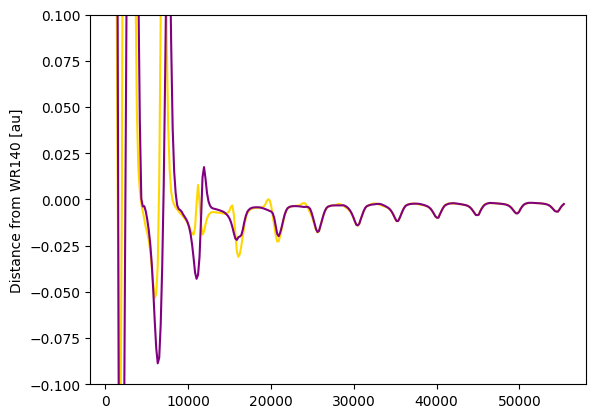

In [135]:
plt.plot(prof_xaxis_img,(prof_img/np.nanmax(prof_img))-prof_model,c="gold",label="Profile Difference (Cycle 1 - Model)")
plt.plot(prof_xaxis_img,(prof_img2/np.nanmax(prof_img2))-prof_model,c="purple",label="Profile Difference (Cycle 2 - Model)")
plt.ylim(-0.1,0.1)
plt.ylabel("Difference in Normalized Flux")
plt.ylabel("Distance from WR140 [au]")